In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os, pickle, argparse, random
import torch, torchvision
from torch import nn
import matplotlib.pyplot as plt

from utils import basic, explainers
from utils.basic import log
from utils import train_engine as tre
from utils import data_process as dp

from timm.utils import NativeScaler
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from tqdm import tqdm

# For visualization
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize
import matplotlib.gridspec as gridspec
plt.rc('text', usetex=True), plt.rc('font', size=25), plt.rc('xtick', labelsize=10), plt.rc('ytick', labelsize=10)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
matplotlib.rcParams['font.family'] = 'Times New Roman'

def init_training_components(m, args):
    scaler = NativeScaler()
    criterion = nn.CrossEntropyLoss(label_smoothing=args.label_smoothing)
    optimizer = create_optimizer(args, m)
    if args.sched is None:
        lr_scheduler = None
    else:
        lr_scheduler, _ = create_scheduler(args, optimizer)
    return scaler, lr_scheduler, optimizer, criterion


In [2]:
''' Global test-case-related configuration '''
DEFAULT_DEVICE = 'cuda'
RANDOM_SEED = 1 # Random seed for reproducibility

# Specify dataset and model 
ROOT_DATA_PTH = './data'
DS_NAME = 'MNIST'   # {'MNIST', 'CIFAR10'}
M_NAME = 'CNN'      # {'CNN', 'WRN40_4'}
IMG_SIZE, NUM_CLASS = (1, 28, 28), 10   

# Specify tested explainer
EXPL_NAME = 'ig'    # Name of explainer, vg, sg, ig, sig are implemented
EXPL_ROOT_DIR = f'./explanations/{DS_NAME}' # Explanation storage root
V_DEFAULT = -dp.MNIST_PIX_MEAN / dp.MNIST_PIX_STD   # Default value for baseline/occlusion
CMAP = 'coolwarm'   # Color code for attribution maps

## From binary to images
This block converts binary storage of ``MNIST``/``CIFAR10`` dataset to ``.png`` format, 
which allows pairing of data samples and their explanations through unique IDs.

In [3]:
def save_images(ds, root_dir):
    for i, p in tqdm(enumerate(ds), total=(len(ds))):
        img, lbl = p 
        dir = f'{root_dir}/{lbl}'
        if not os.path.exists(dir):
            os.makedirs(dir)

        file_pth = f'{dir}/{i}.png'
        img.save(file_pth)
        # imsave(file_pth, img)

# Decompressing data from torchvision APIs for tracebility and pairing with explanations
for set_type in ('test', 'train'):
    img_save_root = f'{ROOT_DATA_PTH}/{DS_NAME}/{set_type}'
    log(f'Creating copy to folder: [{img_save_root}]')
    os.makedirs(img_save_root, exist_ok=True)

    to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
        ])
    ds_api = torchvision.datasets.MNIST
    ds = ds_api(root=f'{ROOT_DATA_PTH}/{DS_NAME}', train=(set_type=='train'), download=True)
    save_images(ds, img_save_root)

INFO[11/15/25,12:02:35]:	Creating copy to folder: [./data/MNIST/test]


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12888.12it/s]


INFO[11/15/25,12:02:35]:	Creating copy to folder: [./data/MNIST/train]


100%|██████████| 60000/60000 [00:03<00:00, 16442.82it/s]


## Model Training

In [3]:
config_pth = f'configs/{DS_NAME}_{M_NAME}_config.yaml'.lower()
config = basic.load_config(config_pth)
parser = argparse.ArgumentParser()
args = argparse.Namespace()
args.__dict__.update(config)
log(args)

INFO[11/16/25,10:36:54]:	Namespace(seed=1, batch_size=256, epochs=30, num_workers=16, label_smoothing=0.0, pin_memory=True, opt='SGD', opt_eps=None, opt_betas=None, clip_grad=None, momentum=0.9, weight_decay=0.0005, lr=0.01, lr_noise=None, warmup_lr=1e-05, min_lr=0.0001, sched='multistep', decay_milestones=[30], decay_rate=0.2, warmup_epochs=0, cooldown_epochs=0, patience_epochs=0)


In [4]:
# Load data
basic.seed_everything(RANDOM_SEED)

input_size = IMG_SIZE
pix_stats = (dp.MNIST_PIX_MEAN, dp.MNIST_PIX_STD)
transform_tr = dp.get_transforms_gray(input_size[-2:], *pix_stats)
transform_val = dp.get_transforms_gray(input_size[-2:], *pix_stats)

train_ds = torchvision.datasets.ImageFolder(f'{ROOT_DATA_PTH}/{DS_NAME}/train', transform_tr)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

test_ds = torchvision.datasets.ImageFolder(f'{ROOT_DATA_PTH}/{DS_NAME}/test', transform_val)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True, num_workers=2)

# Initialize model and saving path
model_dir = f'./models/{DS_NAME}'
os.makedirs(model_dir, exist_ok=True)

m_pth = f'{model_dir}/{DS_NAME.lower()}_{M_NAME.lower()}.pt'
loss_dir = f'{model_dir}/loss'
log(m_pth)
if not os.path.exists(loss_dir):
    os.makedirs(loss_dir)
loss_pth = f'{loss_dir}/{DS_NAME.lower()}_cnn_loss.pkl'
log(loss_pth)

# kwargs = {'input_size': input_size} if M_NAME=='CNN' else {'num_classes': 10}
kwargs = {'input_size': input_size} 
m = dp.M_NAME_DICT[M_NAME](**kwargs)
# components include: scaler, schduler, optimizer, and criterion
components = init_training_components(m, args)

INFO[11/16/25,10:36:56]:	./models/MNIST/mnist_cnn.pt
INFO[11/16/25,10:36:56]:	./models/MNIST/loss/mnist_cnn_loss.pkl


INFO[11/16/25,10:36:57]:	


100%|██████████| 30/30 [01:29<00:00,  2.98s/it, 938/938 | ('LR: 0.010000 Train Loss: 0.0371, Train Acc: 98.97 | Val Loss: 0.0329, Val Acc: 99.10, Best Acc: 99.15',)]

INFO[11/16/25,10:38:26]:	Total training time: 0:01:29


Text(0.5, 1.0, 'Loss on MNIST')

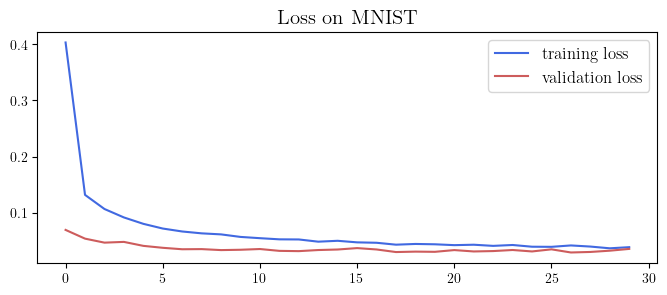

In [5]:
# Model Training
m.to(DEFAULT_DEVICE)
m, tr_ls, val_ls, _ = tre.train(m, train_dl, test_dl, args.epochs, 
                                m_pth, *components)

if loss_pth:
    basic.pkl_dump_wb(loss_pth, (tr_ls, val_ls))

with open(loss_pth, 'rb') as f:
    trs, vals = pickle.load(f)
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(trs, color='royalblue', label='training loss')
ax.plot(vals, color='indianred', label='validation loss')
ax.legend(fontsize=12)
ax.set_title(f'Loss on {DS_NAME}', fontsize=15)

In [6]:
# Running test
m_rl = dp.M_NAME_DICT[M_NAME](**kwargs)
m_rl.load_state_dict(torch.load(m_pth))
m_rl.eval(), m_rl.to(DEFAULT_DEVICE)

acc, loss = tre.val_model(m_rl, test_dl)
log(f'Acc.: [{acc*100:.2f}], Loss: [{loss:.4f}]')

INFO[11/16/25,10:38:27]:	Acc.: [99.15], Loss: [0.0339]


## Model explanation

Initialization for explanation. Explainers implemented in ``utils.explainers`` are:
- VG, SG, IG, and SIG.

Arbitrary explainers can be fitted to the procedure with standardized APIs:
- `` def explain(self, m, img, lbl=None)``

The explainer should offer a function that takes ``m`` (the model), ``img`` (the explicand), and ``lbl`` (the target class) as **input**, returning an attribution map in shape of either ``(C,H,W)`` or ``(H,W)``. The returned feature attribution will be used to generate feature ranking based on both **signed** and **unsigned** attribution scores. The explanation results for one explicand will be saved to three files under the root file of explanations after quantization (to reduce space consumption):
- Feature attribution: ``{img_id}.pkl``
- Feature ranking by signed attribution: ``{img_id}_rank.pkl``
- Feature ranking by attribution magnitude: ``{img_id}_rank_abs.pkl``

In [7]:
""" Initialization for explanation """
# Initializing explainer: VG, SG, IG 
baseline = V_DEFAULT
expl_vg = explainers.VG()
expl_sg = explainers.SG(20, sigma=0.75)
expl_ig = explainers.IG(20, dp.MNIST_IMG_SIZE, baseline=baseline)

expl_dict = {
    'vg': expl_vg,
    'sg': expl_sg,
    'ig': expl_ig,
}
log(f'Saving explanation to: {EXPL_ROOT_DIR}')

# Get dataset-specific preprocessing 
input_size = IMG_SIZE
pix_stats = (dp.MNIST_PIX_MEAN, dp.MNIST_PIX_STD)
transform = dp.get_transforms_gray(input_size[-2:], *pix_stats)

# Load target model 
m_pth = f'./models/{DS_NAME}/{DS_NAME.lower()}_{M_NAME.lower()}.pt'
log(f'Loading model from: {m_pth}')
kwargs = {'input_size': input_size} 
m = dp.ModelWrapper(M_NAME, DEFAULT_DEVICE, m_pth, **kwargs)
m.eval(), m.to(DEFAULT_DEVICE);

INFO[11/16/25,10:39:50]:	Saving explanation to: ./explanations/MNIST
INFO[11/16/25,10:39:50]:	Loading model from: ./models/MNIST/mnist_cnn.pt


In [8]:
''' Explaining and saving results to target folder '''
# Specifying to-be-evaluated explainer
# EXPL_NAME = 'ig'     # Switch to another explainer if intended
expl = expl_dict[EXPL_NAME]

'''
    Only explain a subset of the whole dataset for efficiency.
    Setting ``USED_DATA_RATIO`` up to 1.0 will explain the full dataset, 
    which might take a long time depending on:
        - size of the dataset
        - hardware resources;
        - efficiency of the tested explainer.
'''
USED_DATA_RATIO = 0.1   

for partition in ('test', 'train'):
    sav_dir = f'{EXPL_ROOT_DIR}/{partition}/{EXPL_NAME}'
    os.makedirs(sav_dir, exist_ok=True)
    log(f'Saving explanations to folder: {sav_dir}')

    ds = dp.ImageFolderReturnPaths(f'{ROOT_DATA_PTH}/{DS_NAME}/{partition}', transform)

    basic.seed_everything(RANDOM_SEED)  # Ensuring that different rounds/explainers get the same partition
    ds, _ = torch.utils.data.random_split(ds, [USED_DATA_RATIO, 1-USED_DATA_RATIO])
    dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False, num_workers=2)

    for entry in tqdm(dl):
        img, img_pth, _ = entry
        ypred = m(img.to(DEFAULT_DEVICE))[0].argmax()
        y = ypred.item()    
        attr = expl.explain(m, img[0], lbl=y)
        attr = attr.mean(0) if attr.dim() == 3 else attr    # Force pixel-wise attribution, averaging over channels
        attr_flat = attr.flatten()
        ranking_org = attr_flat.sort(descending=True)[1].tolist()
        ranking_abs = attr_flat.abs().sort(descending=True)[1].tolist()
        # Quantization of the results for storage space efficiency
        attr_int16 = basic.attr_quantization(attr)

        img_id = img_pth[0].split('/')[-1].split('.')[0]
        sav_file_names = [
            f'{sav_dir}/{img_id}.pkl',
            f'{sav_dir}/{img_id}_rank.pkl',
            f'{sav_dir}/{img_id}_rank_abs.pkl'
        ]
        sav_files = [attr_int16, ranking_org, ranking_abs]
        # Dump explanations of corresponding forms to the target folder
        for p in zip(sav_file_names, sav_files): 
            basic.pkl_dump_wb(*p)

INFO[11/16/25,10:39:52]:	Saving explanations to folder: ./explanations/MNIST/test/ig


  2%|▏         | 21/1000 [00:00<00:04, 207.40it/s]

100%|██████████| 1000/1000 [00:01<00:00, 591.77it/s]


INFO[11/16/25,10:39:53]:	Saving explanations to folder: ./explanations/MNIST/train/ig


100%|██████████| 6000/6000 [00:09<00:00, 630.44it/s]


In [9]:
''' Functions for loading explanations and manipulating inputs following explanations '''
def load_expl(expl_dir, img_id):
    expl_pth = f'{expl_dir}/{img_id}.pkl'
    rank_pth = f'{expl_dir}/{img_id}_rank.pkl'
    rank_abs_pth = f'{expl_dir}/{img_id}_rank_abs.pkl'

    attr = pickle.load(open(expl_pth, 'rb')).to(torch.float32)
    attr = attr.mean(0) if attr.dim() == 3 else attr
    attr = attr / attr.abs().max()

    rank = torch.tensor(pickle.load(open(rank_pth, 'rb')))
    rank_abs = torch.tensor(pickle.load(open(rank_abs_pth, 'rb')))
    return attr, rank, rank_abs

# Input manipulation following the order determined by the explanation result
def manipulate(img, rank, v_default, ratio=0.9, lowest_first=True):
    input_size = img.shape
    num_edit = int(input_size[-1] * input_size[-2] * ratio)

    rank = rank.flip(0) if lowest_first else rank
    # Converting 1D index to 2D
    rids, cids = torch.unravel_index(rank[:num_edit], input_size[-2:])
    img[:, rids, cids] = v_default  # Feature occlusion by replacement
    return img

# Update the dataset entity to exclude the un-explained instances
def filter_invalid_entries(ds, expl_dir):
    samples = []
    for p in ds.samples:
        path, _ = p
        id = path.split("/")[-1].split(".")[0]
        expl_pth = f'{expl_dir}/{id}.pkl'
        if os.path.exists(expl_pth):
            samples.append(p)
    ds.samples = samples
    log(f'#Valid entries in {ds.root}: [{len(ds.samples)}]')
    return ds


INFO[11/16/25,10:40:08]:	#Valid entries in ./data/MNIST/test: [1000]


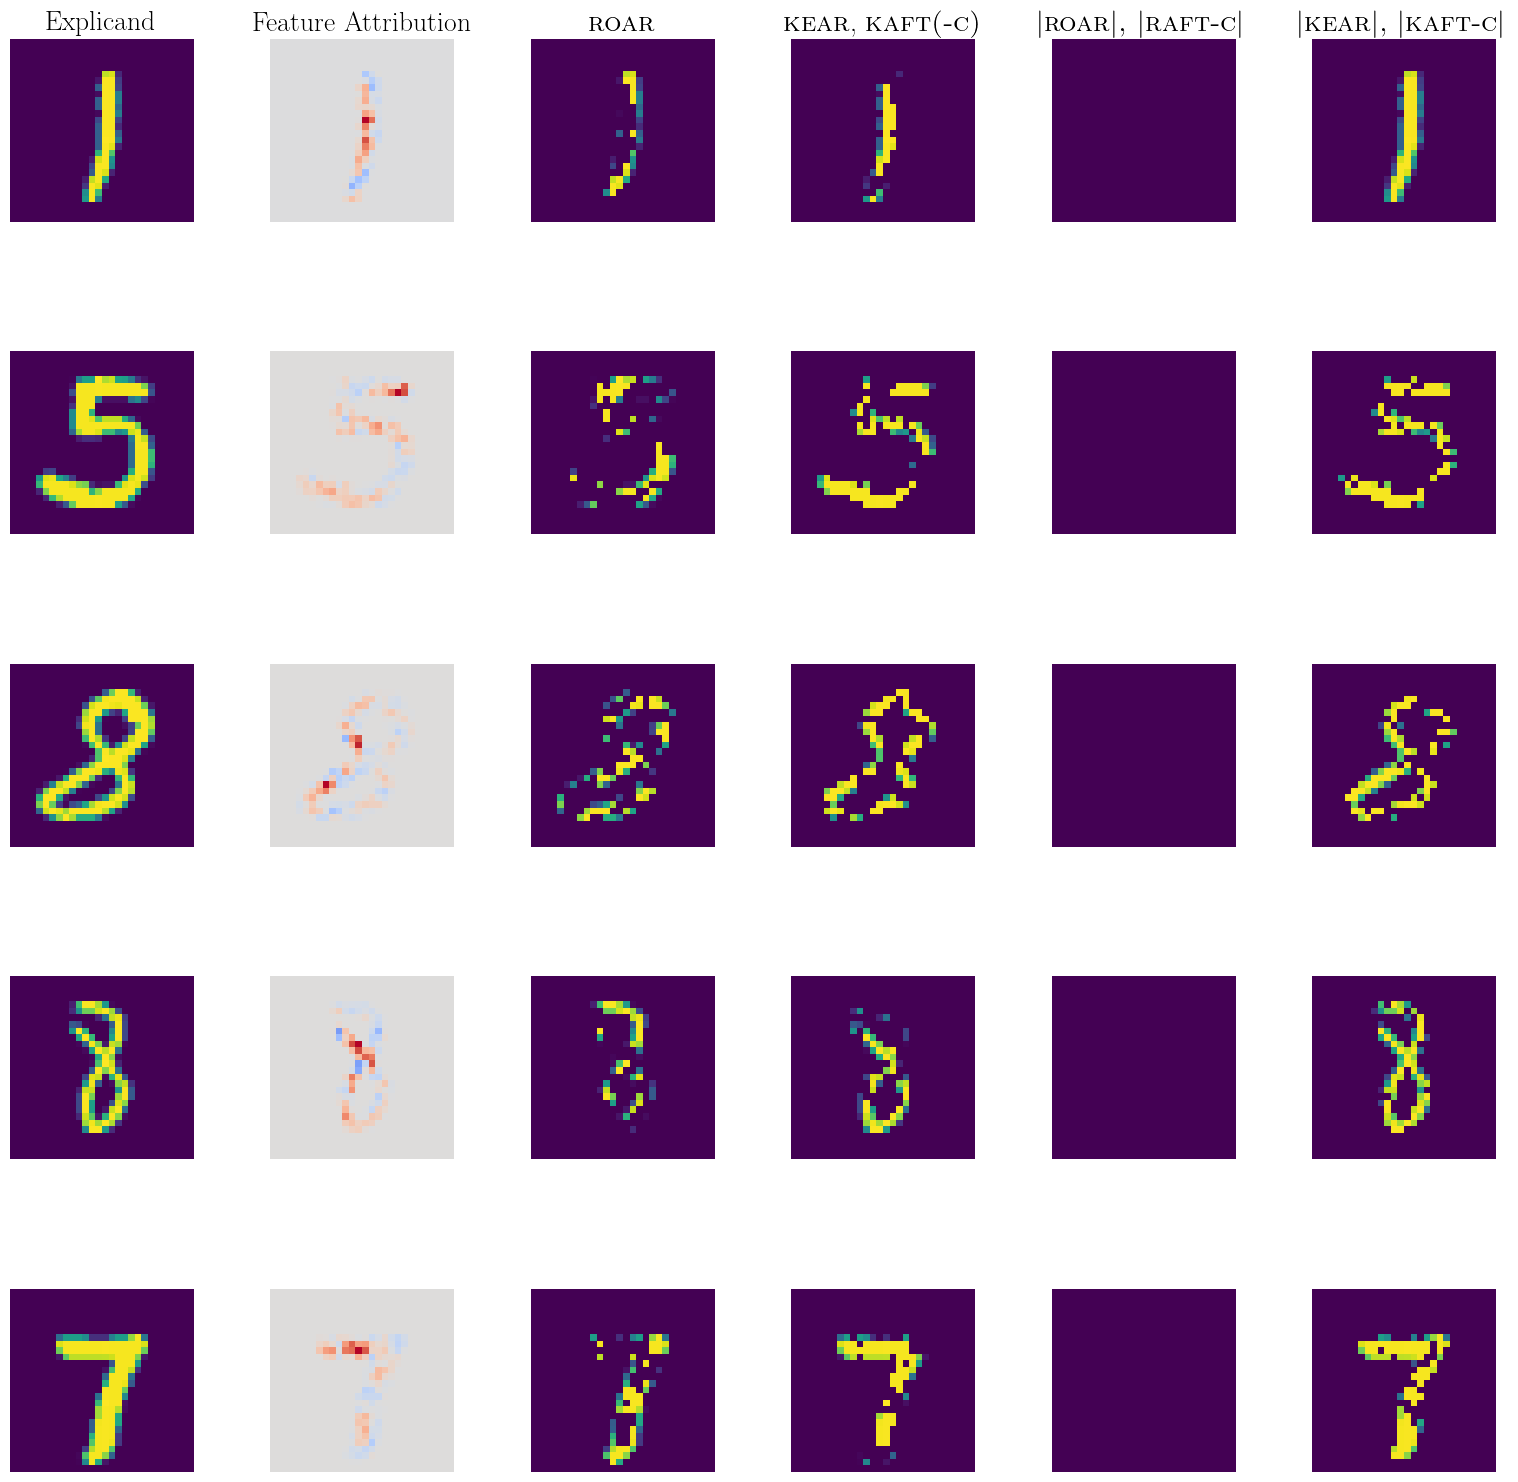

In [10]:
""" Implementing and visualizing explanation-guided feature occlusion """
partition = 'test'
v_default = V_DEFAULT
expl_dir = f'{EXPL_ROOT_DIR}/{partition}/{EXPL_NAME}' 

ds = dp.ImageFolderReturnPaths(f'{ROOT_DATA_PTH}/{DS_NAME}/{partition}', transform)
ds = filter_invalid_entries(ds, expl_dir)
idxs = random.sample(list(range(0, len(ds))), 5)

_, axs = plt.subplots(5, 6, figsize=(16, 16))
plt.tight_layout()

titles = ['Explicand', 'Feature Attribution', r'\textsc{roar}', r'\textsc{kear}, \textsc{kaft(-c)}', r'\textsc{$\vert$roar$\vert$, $\vert$raft-c$\vert$}', r'\textsc{$\vert$kear$\vert$, $\vert$kaft-c$\vert$}']
for ax in axs.flatten(): ax.axis('off')
for ax, s in zip(axs[0], titles): ax.set_title(s, fontsize=20)
for i, idx in enumerate(idxs):
    img, img_pth, _ = ds[idx]
    img_id = img_pth.split('/')[-1].split('.')[0]

    attr, rank, rank_abs = load_expl(expl_dir, img_id)
    # Implementing occlusion with different priorities/strategies
    copy_roar = manipulate(img.clone(), rank, v_default, lowest_first=False)    # ==> ROAR
    copy_kear = manipulate(img.clone(), rank, v_default, lowest_first=True)     # ==> KEAR
    copy_roarAbs = manipulate(img.clone(), rank_abs, v_default, lowest_first=False) # ==> |ROAR|
    copy_kearAbs = manipulate(img.clone(), rank_abs, v_default, lowest_first=True)  # ==> |KEAR|

    norm_img = Normalize(0, 1)
    axs[i][0].imshow(dp.denormalize(img, *pix_stats), norm=norm_img)
    axs[i][1].imshow(attr, norm=TwoSlopeNorm(0, -1, 1), cmap=CMAP)
    axs[i][2].imshow(dp.denormalize(copy_roar, *pix_stats), norm=norm_img)
    axs[i][3].imshow(dp.denormalize(copy_kear, *pix_stats), norm=norm_img)
    axs[i][4].imshow(dp.denormalize(copy_roarAbs, *pix_stats), norm=norm_img)
    axs[i][5].imshow(dp.denormalize(copy_kearAbs, *pix_stats), norm=norm_img)

## Model Retraining/Fine-tuning for validation
The restricted fine-tuning can be generalized to test cases with different models by adapting the ``model_freeze()`` function.

In [5]:
# Load manipulated data with explanation-guided occlusion
def load_ds(ds_pth, partition, rank_type, num_edit, input_size, v_default, flag_keep, transform):
    expl_dir = f'{EXPL_ROOT_DIR}/{partition}/{EXPL_NAME}'
    pth = f'{ds_pth}/{partition}'
    if rank_type is None:
        ds = dp.ImageFolderRandomManip(
            pth, num_edit, input_size, v_default, RANDOM_SEED,
            rank_dir=expl_dir, transform=transform
        )
    else:
        ds = dp.ImageFolderManipulate(
            pth, expl_dir, rank_type, num_edit, input_size, 
            v_default, flag_keep, transform=transform
        )
    return ds

# Restrict the updates to the classification head
def model_freeze(m):
    if M_NAME == 'CNN':
        for name, param in m.named_parameters():
            if 'fc3' in name:
                continue
            param.requires_grad = False
    elif M_NAME == 'WRN40_4':
        for name, param in m.named_parameters():
            if 'fc' in name:
                continue
            param.requires_grad = False
    else:
        assert 1==0, 'UNKNOW MODEL'

In [8]:
''' Loading retraining configuration '''
kwargs = {'input_size': IMG_SIZE} 
m_pth = f'./models/{DS_NAME}/{DS_NAME.lower()}_{M_NAME.lower()}.pt'
config_pth = f'configs/{DS_NAME}_{M_NAME}_retrain_config.yaml'.lower()
config = basic.load_config(config_pth)
parser = argparse.ArgumentParser()
rt_args = argparse.Namespace()
rt_args.__dict__.update(config)
# rt_args.epochs = 20   # Overwrite the manipulation settings if intended
# rt_args.edit_ratio = 0.8
# rt_args.warmup_epochs = 0
msg = [
    f'   --> Retrain epochs: [{rt_args.epochs}]',
    f'   --> Warmup epochs:  [{rt_args.warmup_epochs}]',
    f'   --> Edit ratio:     [{rt_args.edit_ratio}]',
]
log('\n'+'\n'.join(msg))

''' Feature occlusion ratios '''
input_size = IMG_SIZE
pix_stats = (dp.MNIST_PIX_MEAN, dp.MNIST_PIX_STD)
transform = dp.get_transforms_gray(input_size[-2:], *pix_stats)

# EXPL_NAME = 'ig'     # Switch to another explainer if intended
log(f'Loading explanation from: {EXPL_ROOT_DIR}')

num_edit = int(input_size[-2] * input_size[-1] * rt_args.edit_ratio)  # Number of features to occlude

INFO[11/16/25,10:56:56]:	
   --> Retrain epochs: [10]
   --> Warmup epochs:  [1]
   --> Edit ratio:     [0.9]
INFO[11/16/25,10:56:56]:	Loading explanation from: ./explanations/MNIST


In [9]:
""" First specify the occlusion strategy """
occlusion_strategies = [    # rank_type, flag_keep
    ('_rank', True, 'KAFT-C'),          # ==> Correspond to KAFT-C
    ('_rank_abs', True, '|KAFT-C|'),    # ==> Correspond to |KAFT-C|
    ('_rank_abs', False, '|RAFT-C|'),   # ==> Correspond to |RAFT-C|
    (None, None, 'Random'),   # ==> Random removal
]

results = []    # Retraining results are collected as a tuple of (train_loss, val_loss, accuracy)
transform = dp.get_transforms_gray(input_size[-2:], *pix_stats) # Simple transform without augmentation
for rank_type, flag_keep, scheme in occlusion_strategies:
    log('='*20)
    log(f'Testing with {scheme}')
    # Load manipulated data
    train_ds = load_ds(f'{ROOT_DATA_PTH}/{DS_NAME}', 'train', rank_type, num_edit, 
                    input_size, V_DEFAULT, flag_keep, transform)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=16, collate_fn=dp.channels_last_collate)

    test_ds = load_ds(f'{ROOT_DATA_PTH}/{DS_NAME}', 'test', rank_type, num_edit, 
                    input_size, V_DEFAULT, flag_keep, transform)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=16, collate_fn=dp.channels_last_collate)

    m = dp.M_NAME_DICT[M_NAME](**kwargs)    # Get model structure according to model name
    log(f'Loading model from: {m_pth}')
    m.load_state_dict(torch.load(m_pth))
    m.to(DEFAULT_DEVICE)
    components = init_training_components(m, rt_args)
    model_freeze(m) # Freeze model for restricted update

    # Report the training & validation outcomes 
    m, tr_ls, val_ls, _ = tre.train(m, train_dl, test_dl, rt_args.epochs, None, *components)
    acc, _ = tre.val_model(m, test_dl)
    results.append((tr_ls, val_ls, acc))
    print('\n')

INFO[11/16/25,10:56:57]:	====================
INFO[11/16/25,10:56:57]:	#Valid entries in ./data/MNIST/train: [6000]
INFO[11/16/25,10:56:57]:	#Valid entries in ./data/MNIST/test: [1000]
INFO[11/16/25,10:56:57]:	Loading model from: ./models/MNIST/mnist_cnn.pt
INFO[11/16/25,10:56:57]:	Testing with KAFT-C

INFO[11/16/25,10:56:57]:	


100%|██████████| 10/10 [00:06<00:00,  1.63it/s, 94/94 | ('LR: 0.009640 Train Loss: 0.0902, Train Acc: 98.42 | Val Loss: 0.1023, Val Acc: 98.50, Best Acc: 0.00',)]

INFO[11/16/25,10:57:03]:	Total training time: 0:00:06


INFO[11/16/25,10:57:04]:	====================
INFO[11/16/25,10:57:04]:	#Valid entries in ./data/MNIST/train: [6000]
INFO[11/16/25,10:57:04]:	#Valid entries in ./data/MNIST/test: [1000]
INFO[11/16/25,10:57:04]:	Loading model from: ./models/MNIST/mnist_cnn.pt
INFO[11/16/25,10:57:04]:	Testing with |KAFT-C|

INFO[11/16/25,10:57:04]:	


100%|██████████| 10/10 [00:06<00:00,  1.65it/s, 94/94 | ('LR: 0.009640 Train Loss: 0.1291, Train Acc: 96.47 | Val Loss: 0.0953, Val Acc: 97.30, Best Acc: 0.00',)]

INFO[11/16/25,10:57:10]:	Total training time: 0:00:06


INFO[11/16/25,10:57:10]:	====================
INFO[11/16/25,10:57:10]:	#Valid entries in ./data/MNIST/train: [6000]
INFO[11/16/25,10:57:10]:	#Valid entries in ./data/MNIST/test: [1000]
INFO[11/16/25,10:57:10]:	Loading model from: ./models/MNIST/mnist_cnn.pt
INFO[11/16/25,10:57:10]:	Testing with |RAFT-C|

INFO[11/16/25,10:57:10]:	


100%|██████████| 10/10 [00:06<00:00,  1.62it/s, 94/94 | ('LR: 0.009640 Train Loss: 2.3054, Train Acc: 10.43 | Val Loss: 26.5435, Val Acc: 12.90, Best Acc: 0.00',)]

INFO[11/16/25,10:57:16]:	Total training time: 0:00:06


INFO[11/16/25,10:57:16]:	====================
INFO[11/16/25,10:57:17]:	#Valid entries in ./data/MNIST/train: [6000]
INFO[11/16/25,10:57:17]:	#Valid entries in ./data/MNIST/test: [1000]
INFO[11/16/25,10:57:17]:	Loading model from: ./models/MNIST/mnist_cnn.pt
INFO[11/16/25,10:57:17]:	Testing with Random

INFO[11/16/25,10:57:17]:	


100%|██████████| 10/10 [00:06<00:00,  1.51it/s, 94/94 | ('LR: 0.009640 Train Loss: 2.0158, Train Acc: 29.50 | Val Loss: 1.8705, Val Acc: 37.10, Best Acc: 0.00',)]

INFO[11/16/25,10:57:23]:	Total training time: 0:00:06


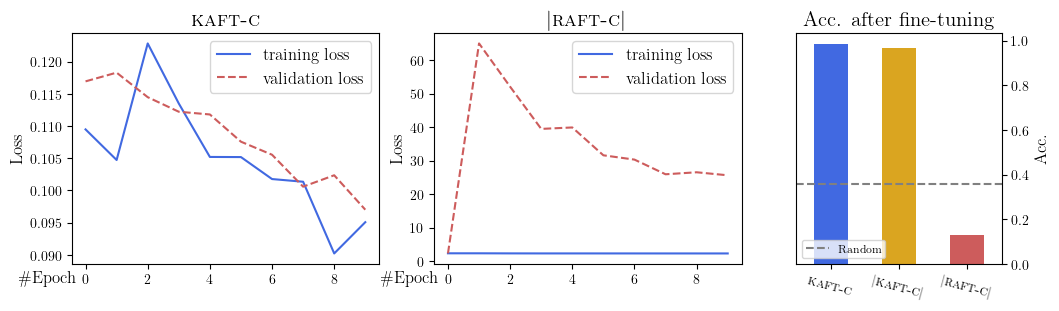

In [22]:
small_text_size = 12
title_text_size = 15

fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 3, 2])
plt.tight_layout()

titles = [r'\textsc{kaft-c}', r'\textsc{$\vert$raft-c$\vert$}']
target_results = [results[0], results[2]]   # Training losses of KAFT and |RAFT|

# Show retraining losses of the selected schemes
for idx, res in enumerate(target_results):
    title = titles[idx]
    ax_plot = fig.add_subplot(gs[idx])
    ax_plot.set_title(title, fontsize=title_text_size)
    ax_plot.plot(res[0], linestyle='-', color='royalblue', label='training loss')
    ax_plot.plot(res[1], linestyle='--', color='indianred', label='validation loss')

    ax_plot.set_ylabel('Loss', fontsize=small_text_size)
    ax_plot.set_xlabel('\#Epoch', fontsize=small_text_size)
    ax_plot.xaxis.set_label_coords(-0.08, -0.03)
    ax_plot.legend(fontsize=small_text_size)

# Show retraining accuracies
ax_plot = fig.add_subplot(gs[2])
bar_colors = ['royalblue', 'goldenrod', 'indianred']
scheme_names = [r'\textsc{kaft-c}', r'\textsc{$\vert$kaft-c$\vert$}', r'\textsc{$\vert$raft-c$\vert$}']
for idx, scheme in enumerate(scheme_names):
    acc, color = results[idx][-1], bar_colors[idx]
    ax_plot.bar(idx, acc, width=0.5, color=color, )
ax_plot.set_xlim([-0.5, 2.5])
ax_plot.set_xticks(list(range(3)))
ax_plot.set_xticklabels([r'\textsc{kaft-c}', r'\textsc{$\vert$kaft-c$\vert$}', r'\textsc{$\vert$raft-c$\vert$}'], rotation=-15)
ax_plot.set_ylabel('Acc.', fontsize=small_text_size)
ax_plot.yaxis.tick_right(), ax_plot.yaxis.set_label_position('right')
ax_plot.set_title('Acc. after fine-tuning', fontsize=title_text_size)

random_acc = results[-1][-1]
ax_plot.hlines(random_acc, -0.5, 2.5, linestyles='--', color='gray', label='Random')
ax_plot.legend(fontsize=small_text_size-4, loc='lower left')

# texts = [
#     'Training losses during fine-tuning following different schemes, and final accuracies',
#     '(Please note the different scale of y-axis)'
# ]
# fig.suptitle('\n'.join(texts), y=0.0, fontsize=title_text_size);

The results show that IG achieves the best performance under the **KAFT-C** scheme. This demonstrates the benign behavior of IG: keeping the features that positively contribute to predicting the target class results in minimal performance degradation.

Additionally, while the occlusion following |KAFT-C| preserves all task-relevant information and, from a human perspective, leads to a better representation of the target object after perturbation (given the better concentration on the target), including negatively contributing features, in fact, undermines the utility of the manipulated dataset.  This observation aligns with the semantic meaning of the sign of attribution scores, and the misalignment between machine behaviors and human expectations underlines the **paradox of explanation evaluation**.
